#About the data

google stock price where we are only interseted in open google stock price

so the first two columns in the dataset is only important,which is the open columns


###Prepocessing the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

In [9]:
dataset_train.shape

(1258, 6)

In [10]:
train_dataset = dataset_train.iloc[:, 1:2].values#extarcting the column for normalizing


Neural Network alway should be normalized or scaled

here we are using minmax scaling to get all the stock prices between 0 and 1


In [20]:
from pandas.core.tools.datetimes import Scalar
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
training_set_scaled = scalar.fit_transform(train_dataset)
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

###Building the model

for RNN we need to always give the past input with which it predcits the next output for this we are providng 60 time steps

In [21]:
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [26]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #input shape for the neural_network

In [28]:
X_train.shape

(1198, 60, 1)

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

unit (number of memory units)

return_sequences = True (Creating a sta cked LSTN layer one after the other we have to set it True once we stop adding the LstM layer then it should be set to false but which is done default )

input_shape (input shape time steps and indicators)

In [32]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))#Adding the first  LSTM which involves the input
regressor.add(Dropout(0.2)) #'regulristaion is used to avoid overfitting we are dropping 20 % of neurons be dropped out (ie 20% of 50 which is 10)
regressor.add(LSTM(units = 50, return_sequences = True)) #Adding the second layer
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))#Adding the third layer
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

#compileing the model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fitting the model

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 15s 158ms/step - loss: 0.0492
Epoch 2/100
38/38 [==============================] - 5s 120ms/step - loss: 0.0064
Epoch 3/100
38/38 [==============================] - 6s 154ms/step - loss: 0.0057
Epoch 4/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0055
Epoch 5/100
38/38 [==============================] - 5s 123ms/step - loss: 0.0058
Epoch 6/100
38/38 [==============================] - 6s 157ms/step - loss: 0.0048
Epoch 7/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0044
Epoch 8/100
38/38 [==============================] - 6s 150ms/step - loss: 0.0043
Epoch 9/100
38/38 [==============================] - 7s 193ms/step - loss: 0.0041
Epoch 10/100
38/38 [==============================] - 10s 256ms/step - loss: 0.0046
Epoch 11/100
38/38 [==============================] - 6s 163ms/step - loss: 0.0042
Epoch 12/100
38/38 [==============================] - 8s 210ms/step - loss: 0.0041
Epoch 13/10

#Making the predictions and visualising

In [33]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [34]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scalar.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scalar.inverse_transform(predicted_stock_price)

1/1 [==============================] - 2s 2s/step


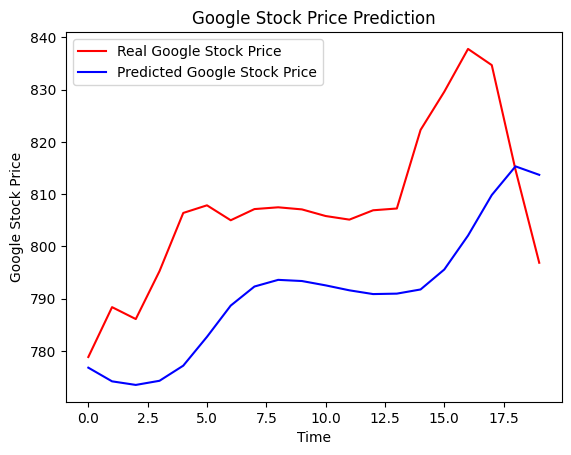

In [35]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

#Evaluating the RNN model

our specific Stock Price Prediction problem, evaluating the model with the RMSE does not make much sense, since we are more interested in the directions taken by our predictions, rather than the closeness of their values to the real stock price. We want to check if our predictions follow the same directions as the real stock price and we don’t really care whether our predictions are close the real stock price. The predictions could indeed be close but often taking the opposite direction from the real stock price

In [36]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

In [37]:
rmse

20.396115213864473

#Improving the RNN model
Getting more training data: we trained our model on the past 5 years of the Google Stock Price but it would be even better to train it on the past 10 years.
Increasing the number of timesteps: the model remembered the stock prices from the 60 previous financial days to predict the stock price of the next day. That’s because we chose a number of 60 timesteps (3 months). You could try to increase the number of timesteps, by choosing for example 120 timesteps (6 months).
Adding some other indicators: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data.
Adding more LSTM layers: we built a RNN with four LSTM layers but you could try with even more.
Adding more neurones in the LSTM layers: we highlighted the fact that we needed a high number of neurones in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurones in each of our 4 LSTM layers. You could try an architecture with even more neurones in each of the 4 (or more) LSTM layers.